# Reaction Rate Fields and Reactors

## Upgrade the Package `chbe444umd`
+ Upgrading will enable you to access its latest capabilities.
+ To install, run:
  >`%pip install chbe444umd`
+ To upgrade, run:
  >`%pip install --upgrade chbe444umd`
+ Restart the kernel after installing or upgrading.

## 0. Introduction

This script plots the reaction rate field for the system A $\rightarrow$ B $\rightarrow$ C, 2 A $\rightarrow$ D with van de Vusse kinetics, covered in lectures F.01 and F.02 of Module F.

The kinetics of the reactions are as follows:

|Reaction|Rate expression|Units|
|:------:|:-------------:|:----|
|$r_1$   | $k_1 C_A$     |$M/s$|
|$r_2$   | $k_2 C_B$     |$M/s$|
|$r_3$   | $k_3 C_A^2$   |$M/s$|

Let us use the same rate constants we used in previous assignments involving this reaction system: $k_1 = 1.0 h^{-1}$, $k_2 = 1.0 h^{-1}$, $k_3 = 10.0 M^{-1}h^{-1}$. 

## 1. Specify Reaction System and Plot Rate Field

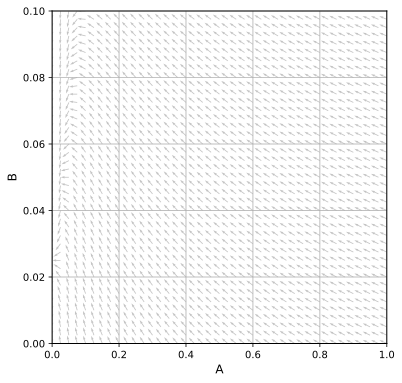

In [1]:
import chbe444umd as des

sysABCD = des.ReactionSystem(
    component_ids=('A', 'B', 'C', 'D'),
    component_names={'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D'},
    axes={'A': 0, 'B': 1},
    h_lim=[0, 1],
    v_lim=[0, 0.1],
    reactions=('r1', 'r2', 'r3'),
    stoich={'r1': {'A': -1, 'B': 1},
            'r2': {'B': -1, 'C': 1},
            'r3': {'A': -2, 'D': 1}},
    kinetics={'r1': lambda C: 1.0 * C['A'],
              'r2': lambda C: 1.0 * C['B'],
              'r3': lambda C: 10.0 * C['A']**2},
    inequality=lambda C: 0
)

%config InlineBackend.figure_format='svg'
%matplotlib inline

fig, ax, _ = sysABCD.plot_rate_field(fsize=6, n_vec=41, arrow_scale=41)

## 2. Specify and Simulate Reactors

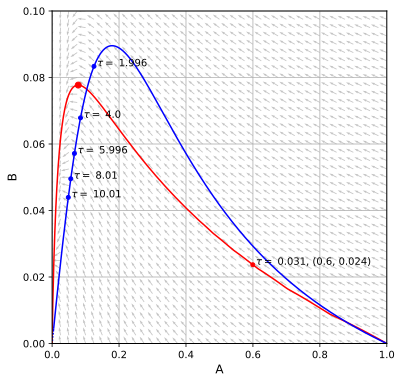

In [2]:
import numpy as np

# PFR with a fresh feed at [1, 0]
pfr1 = des.Reactor(name='PFR1', flow_type='pfr', feed=[1, 0])
pfr1.simulate(system=sysABCD, ax=ax, time_limit=10)

# CSTR with fresh feed at [1, 0]
cstr1 = des.Reactor(name='CSTR1', flow_type='cstr', feed=[1, 0], time=1000)
cstr1.simulate(system=sysABCD, ax=ax)

# Plot points
pfr1.plot_point(ax, x=0.6)
pfr1.plot_point(ax, y=0.1, markersize=6, annotate=False)  # closest match will be found
[cstr1.plot_point(ax, tau=tau, annotation='tau') for tau in np.linspace(2, 10, 5)]

fig  # update the figure at the end

## 3. Perform annotations and attainable region (AR) constructions

### 3.1 Draw tangents to reactor curves from specified points

+ If you plot the tangents from `[1, 0]`, you will get tangents to the reactor passing through `[1, 0]`, since it is point on both reactors. Therefore, draw the tangents from something like `[1, 5e-4]`.
+ To plot a common tangent to two reactor curves, use the function `common_tangent`. See the example.
+ To get help with this function, run:
  >`des.common_tangent?`

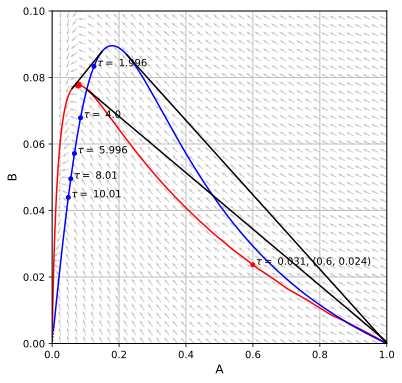

In [3]:
ax, tangent1 = pfr1.plot_tangent(ax, from_point=[1, 5e-4], color='k')  # 'k' = black

ax, tangent2 = cstr1.plot_tangent(ax, from_point=[1, 1e-6], color='k', tol=1e-3)  # 'k' = black

ax, tangent3 = des.common_tangent(ax, pfr1, cstr1,
                                  near_point=[0.1, 0.08], distance_y = 0.01,
                                  tol=1e-1)

fig  # update figure after completing all constructions

### 3.2 Draw initial convex hull (draft of attainable region)

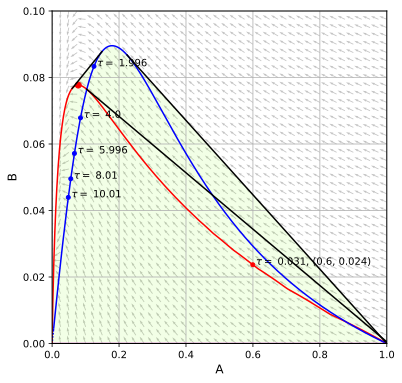

In [4]:
line, = ax.plot([1, 0], [0, 0], 'm-')  # baseline from [0, 0] to [1, 0]

des.convexify(ax, boundaries=[pfr1, cstr1, line],
              lw=0, color='#80ff00', alpha=0.1)

fig

# Revise convex hull (final attainable region)

+ Since rate vectors are pointing out at the northwest of the draft AR, we will need to draw a PFR to contain the vectors.
+ The PFR must be drawn from the point at which the tangent from the feed to the CSTR ends.
+ We can query the tangent object `tangent2` to get the exact coordinates of the feed of the new PFR.

In [5]:
X = tangent2.get_xdata()[1]
Y = tangent2.get_ydata()[1]
print(X, Y)

0.2237541917679989 0.0867867867867868


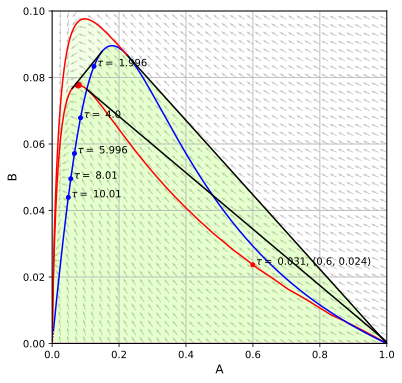

In [6]:
pfr2 = des.Reactor(name='PFR2', flow_type='pfr', feed=[X, Y])
pfr2.simulate(system=sysABCD, ax=ax, time_limit=10)

des.convexify(ax, boundaries=[cstr1, pfr2, line],
              lw=0, color='#80ff00', alpha=0.1)

fig